## Week 7 Class 1 Logical Constraints - Capital Budgeting

# Table of Contents<a id="Top"></a>

1. [Problem Statement](#1)<br>
2. [Data](#2) <br>
3. [Model Definition](#3)<br>
4. [Model Solution](#4)<br>
5. [Sensitivity Analysis](#5)<br>
    5.1 [Increase NPV](#5.1)<br>
    5.2 [Increase Expenditure](#5.2)<br>
    5.3 [Increase both NPV and Expenditure](#5.3)

## 1. Problem Statement<a id="1"></a>

In this example, we have a Capital Budgeting problem that we first looked at in chapter 6 (OM 6.2). 
* Classic example:  capital budgeting
* A company has 5 capital projects (P1, P2, P3, P4, P5) they are considering 
* They know the net present value (NPV) of each asset, as well as the expenditure needed for each project
* Question: Which subset of the projects should they pursue that maximizes NPV, subject to a $40M budget?

We now have expanded our constraints to include the last 4 logical constraints:
 * Binary DV (choose or not)
 * Stay within budget of 40
 * Requires 1 Int'l Project: P2 or P5 -> P2 + P5 >=1
 * P2 and P3 mutually exclusive -> P2 + P3 <=1
 * P2 is contingent on P5 -> P5 - P2 >=0
 * P4 is contingent on P5 -> P5 - P4 >=0
 
### Note:
This problem is similar, albeit a simpler version, of the problem that you will need to solve for the project. 

##### [Back to Top](#Top)

## 2. Data<a id="2"></a>

In [1]:
import pandas as pd
import pyomo.environ as pe
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

Import the data from the excel file `07-c01-logical-cap-bud.xlsx`. Make sure to import from the `Capital Budget` sheet.

In [3]:
df = pd.read_excel("w07-c01-logical-cap-bud.xlsx", sheet_name = "Capital Budget")
df

,Data,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,ALL CONSTRAINTS,Unnamed: 10
0,NaN,Project,P1,P2,P3,P4,P5,NaN,NaN,Binary DV (choose or not),NaN
1,NaN,NPV,1.9,3.6,3.1,1.6,2.8,NaN,NaN,Stay within budget of 40,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Requires 1 Int'l Project (P2/P5),NaN
3,Objective: Maximize NPV,NaN,6.6,NaN,NaN,NaN,NaN,NaN,NaN,P2 and P3 mutually exclusive,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P2 is contingent on P5,NaN
5,NaN,NaN,P1,P2,P3,P4,P5,NaN,NaN,P4 is contingent on P5,NaN
6,Decisions: Accept or not?,NaN,1,0,1,1,0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Constraints,NaN,NaN,NaN,NaN,NaN,NaN,LHS,Eq/InEq,RHS,NaN
9,NaN,Expenditure,12,24,20,8,16,40,<=,40,Stay within budget


Create a dataframe 'coef' to hold the coefficients of the objective function (NPV) and the LHS of the expenditure and logical constraints.

In [4]:
DV_indexes = ['P1', 'P2', 'P3', 'P4', 'P5']
coef = pd.DataFrame(df.iloc[[1, 9], 2:7])
coef.index = ['NPV', 'expenditure']
coef.columns = DV_indexes
coef

,P1,P2,P3,P4,P5
NPV,1.9,3.6,3.1,1.6,2.8
expenditure,12,24,20,8,16


Next create a dataframe 'rhs' to hold the RHS of the expenditure constraint. Note we are just creating this rather than reading it in from Excel.

In [5]:
rhs = pd.DataFrame({'rhs': 40}, index= ['expenditure'])
rhs

,rhs
expenditure,40


##### [Back to Top](#Top)

## 3. Model Definition<a id="3"></a>

Next we will create a Pyomo model. First instantiate a ConcreteModel and store it in the variable model.

In [6]:
model = pe.ConcreteModel()

### Define Decision Variables

In [7]:
model.x = pe.Var(DV_indexes, domain = pe.Binary)
model.x.pprint()

x : Size=5, Index=x_index
    Key : Lower : Value : Upper : Fixed : Stale : Domain
     P1 :     0 :  None :     1 : False :  True : Binary
     P2 :     0 :  None :     1 : False :  True : Binary
     P3 :     0 :  None :     1 : False :  True : Binary
     P4 :     0 :  None :     1 : False :  True : Binary
     P5 :     0 :  None :     1 : False :  True : Binary


### Define Objective Function

In [8]:
model.obj = pe.Objective(expr = sum([coef.loc['NPV', index]*model.x[index] for index in DV_indexes]), 
                         sense = pe.maximize)
model.obj.pprint()

obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : 1.9*x[P1] + 3.6*x[P2] + 3.1*x[P3] + 1.6*x[P4] + 2.8*x[P5]


### Define Constraints

Next we need to define the five constraints using the data in the coefficients and rhs dataframes. Note the first two are <= and the remainder are >=. We are just solving the initial problem (last class) first. 

In [9]:
#Stay within budget of 40
model.cons_expen = pe.Constraint(expr = sum([coef.loc['expenditure', idx]*model.x[idx] 
                                             for idx in DV_indexes]) <= rhs.loc['expenditure','rhs'])

##### [Back to Top](#Top)

## 4. Model Solution<a id="4"></a>

Now it is time to solve the model!

In [10]:
opt = pe.SolverFactory('glpk')
success = opt.solve(model)
print(success.solver.status, success.solver.termination_condition)

ok optimal


### Optimal Objective Value

In [11]:
obj_val = model.obj.expr()
#Note uses printmd
printmd(f'optimal objective value maximimizes NPV = ${obj_val:.2f} million')

optimal objective value maximimizes NPV = $6.60 million

In [12]:
print(f'optimal objective value maximimizes NPV = ${obj_val:.2f} million')

optimal objective value maximimizes NPV = $6.60 million


### Optimal Decision Variables

In [13]:
# Using this list of variable names,
#Let's create a DataFrame with the decision variable values
DV_solution = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for var in DV:
        DV_solution.loc[DV.name, var] = DV[var].value
DV_solution

,P1,P2,P3,P4,P5
x,1.0,0.0,1.0,1.0,0.0


Let's create a `results` dataframe that adds on the objective function optimal value in the data frame.

In [14]:
results = DV_solution
results['opt profit'] = obj_val #adds a new column
results.index = ['orig']
results

,P1,P2,P3,P4,P5,opt profit
orig,1.0,0.0,1.0,1.0,0.0,6.6


Do we have any slack in our expense constraint?

In [15]:
print(model.cons_expen.body())
print(model.cons_expen.slack())

40.0
0.0


In [16]:
model.display()

Model unknown

  Variables:
    x : Size=5, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
         P1 :     0 :   1.0 :     1 : False : False : Binary
         P2 :     0 :   0.0 :     1 : False : False : Binary
         P3 :     0 :   1.0 :     1 : False : False : Binary
         P4 :     0 :   1.0 :     1 : False : False : Binary
         P5 :     0 :   0.0 :     1 : False : False : Binary

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   6.6

  Constraints:
    cons_expen : Size=1
        Key  : Lower : Body : Upper
        None :  None : 40.0 :  40.0


##### [Back to Top](#Top)

### New Model

In [17]:
model = pe.ConcreteModel()
model.x = pe.Var(DV_indexes, domain = pe.Binary)
model.obj = pe.Objective(expr = sum([coef.loc['NPV', index]*model.x[index] for index in DV_indexes]),
                         sense = pe.maximize)

In [18]:
#Stay within budget of 40
model.cons_expen = pe.Constraint(expr = sum([coef.loc['expenditure', idx]*model.x[idx] 
                                             for idx in DV_indexes]) <= rhs.loc['expenditure','rhs'])
#Logical Constraints
#Requires 1 Int'l Project: P2 or P5 -> P2 + P5 >=1
model.cons_IntlP2P5 = pe.Constraint(expr = model.x['P2'] + model.x['P5']  >= 1)

#P2 and P3 mutually exclusive -> P2 + P3 <=1
model.cons_P2P3ME = pe.Constraint(expr = model.x['P2'] + model.x['P3'] <= 1)

#P2 is contingent on P5 -> P5-P2 >=0
model.cons_P2contonP5 = pe.Constraint(expr = model.x['P5'] - model.x['P2'] >= 0)

#P4 is contingent on P5 -> P5 - P4 >=0
model.cons_P4contonP5 = pe.Constraint(expr = model.x['P5'] - model.x['P4'] >= 0)

In [19]:
for con in model.component_objects(pe.Constraint):
    print(con, con.pprint())

cons_expen : Size=1, Index=None, Active=True
    Key  : Lower : Body                                                : Upper : Active
    None :  -Inf : 12*x[P1] + 24*x[P2] + 20*x[P3] + 8*x[P4] + 16*x[P5] :  40.0 :   True
cons_expen None
cons_IntlP2P5 : Size=1, Index=None, Active=True
    Key  : Lower : Body          : Upper : Active
    None :   1.0 : x[P2] + x[P5] :  +Inf :   True
cons_IntlP2P5 None
cons_P2P3ME : Size=1, Index=None, Active=True
    Key  : Lower : Body          : Upper : Active
    None :  -Inf : x[P2] + x[P3] :   1.0 :   True
cons_P2P3ME None
cons_P2contonP5 : Size=1, Index=None, Active=True
    Key  : Lower : Body          : Upper : Active
    None :   0.0 : x[P5] - x[P2] :  +Inf :   True
cons_P2contonP5 None
cons_P4contonP5 : Size=1, Index=None, Active=True
    Key  : Lower : Body          : Upper : Active
    None :   0.0 : x[P5] - x[P4] :  +Inf :   True
cons_P4contonP5 None


In [20]:
opt = pe.SolverFactory('glpk')
success = opt.solve(model)
print(success.solver.status, success.solver.termination_condition)

ok optimal


In [21]:
obj_val = model.obj.expr()
#Note uses printmd
printmd(f'optimal objective value maximimizes NPV = ${obj_val:.2f} million')

optimal objective value maximimizes NPV = $6.40 million

In [22]:
results = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for var in DV:
        results.loc[DV.name, var] = DV[var].value
results['opt profit'] = obj_val #adds a new column
results.index = ['orig']
results

,P1,P2,P3,P4,P5,opt profit
orig,0.0,1.0,0.0,0.0,1.0,6.4


## 5. Sensitivity Analysis<a id="5"></a>

Now, let's try to get some strategic information to see what else we can learn about this model.

The above model is based on current conditions, but we are wondering how the maximum NPV and choice of decision variables will be affected by potential future changes to our operations. Let's say that we want to test the sensitivity of this model based on 3 different items:
* Increase the NPV for project 4 by .3.
* Increase the expenditures of project 5 by 4.5
* Increase the expenditure of project 5 by 4.5 and increase the NPV for project 4 by .3

### Create a function that runs the model

Copy all the above model creation code without any thing "extraneous" and put it in the function `def run_model()`. At the end use `return model`. Make sure all the code is indented the same under the `def` line.

In [23]:
def run_model():
    model = pe.ConcreteModel()
    # Define Decision Variables
    model.x = pe.Var(DV_indexes, domain=pe.Binary)
    # Define Objective Function for profit
    model.obj = pe.Objective(expr=sum([coef.loc['NPV',c]*model.x[c] 
                                   for c in DV_indexes]), 
                         sense=pe.maximize)    #Stay within budget of 40
    model.cons_expen = pe.Constraint(expr=sum([coef.loc['expenditure', c]*model.x[c] 
                                               for c in DV_indexes]) <= rhs.loc['expenditure','rhs'])
    #Logical Constraints
    #Requires 1 Int'l Project: P2 or P5 -> P2 + P5 >=1
    model.cons_P2P3ME = pe.Constraint(expr=model.x['P2']+model.x['P5']  >= 1)
    #P2 and P3 mutually exclusive -> P2 + P3 <=1
    model.cons_IntlP2P5 = pe.Constraint(expr=model.x['P2']+model.x['P3'] <= 1)
    #P2 is contingent on P5 -> P5-P2 >=0
    model.cons_P2contonP5 = pe.Constraint(expr=model.x['P5']-model.x['P2'] >= 0)
    #P4 is contingent on P5 -> P5 - P4 >=0
    model.cons_P4contonP5 = pe.Constraint(expr=model.x['P5']-model.x['P4'] >= 0)
    opt = pe.SolverFactory('glpk')
    #opt.solve(model,tee=True) 
    success = opt.solve(model)
    return model

Capture the original `coef` table so we can reset the model each time. Note if we are going to change the values, rather than use a reference we want to use the `.copy()` function so that it will make a hard copy and not just a soft copy and remove references to the original dataframe.

In [24]:
coef_orig = coef.copy()
coef_orig

,P1,P2,P3,P4,P5
NPV,1.9,3.6,3.1,1.6,2.8
expenditure,12,24,20,8,16


### 5.1 Increase the NPV<a id=5.1></a>

First we'll update the data by changing the `coef` table NPV for project 4 to be this new value which is the original + .3.

In [25]:
coef = coef_orig.copy() #reset to original
coef.loc['NPV', 'P4'] = coef.loc['NPV','P4'] + .3
coef

,P1,P2,P3,P4,P5
NPV,1.9,3.6,3.1,1.9,2.8
expenditure,12,24,20,8,16


Now rerun the model with your new function and view the new optimal values

In [26]:
model = run_model()

obj_val = model.obj.expr()
printmd(f'optimal objective value maximum profit = ${obj_val:.2f}')

optimal objective value maximum profit = $6.60

In [27]:
DV_solution = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for c in DV:
        DV_solution.loc[DV.name,c] = DV[c].value
DV_solution.index = ['NPV P4 .30']
DV_solution

,P1,P2,P3,P4,P5
NPV P4 .30,1.0,0.0,0.0,1.0,1.0


Oh yeah, but what was the original? Let's look at the results table and add this new row to it.

In [28]:
results = results.append(DV_solution)
results.loc['NPV P4 .30','opt profit'] = obj_val
results

,P1,P2,P3,P4,P5,opt profit
orig,0.0,1.0,0.0,0.0,1.0,6.4
NPV P4 .30,1.0,0.0,0.0,1.0,1.0,6.6


In [29]:
printmd('Our model if we increase the NPV of Project 4 of .3 we change the decision variables project choices')
printmd(f'and the new NPV is now ${obj_val:.2f} million')
printmd(f'and we should invest in projects 1 and 5 but swap to project 4 instead of 2.')

Our model if we increase the NPV of Project 4 of .3 we change the decision variables project choices

and the new NPV is now $6.60 million

and we should invest in projects 1 and 5 but swap to project 4 instead of 2.

### 5.2 Increase the Expenditure<a id=5.2></a>

Ok, so what if we have to increase expenditures of project 5 by 4.5? Now we'll update the data by changing the coef table NPV for project 4 to be this new value which is the original + 4.5. We will get rid of the previous changes first.

In [30]:
coef = coef_orig.copy() #reset to original
coef.loc['expenditure', 'P5'] = coef.loc['expenditure', 'P5'] + 4.5
coef

,P1,P2,P3,P4,P5
NPV,1.9,3.6,3.1,1.6,2.8
expenditure,12,24,20,8,20.5


Then we'll update the model

In [31]:
model = run_model()

obj_val = model.obj.expr()
printmd(f'optimal objective value maximum profit = ${obj_val:.2f} million')

optimal objective value maximum profit = $4.70 million

In [32]:
DV_solution = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for c in DV:
        DV_solution.loc[DV.name,c] = DV[c].value
DV_solution.index = ['Exp P5 4.5']
DV_solution

,P1,P2,P3,P4,P5
Exp P5 4.5,1.0,0.0,0.0,0.0,1.0


In [33]:
results = results.append(DV_solution)
results.loc['Exp P5 4.5','opt profit'] = obj_val
results

,P1,P2,P3,P4,P5,opt profit
orig,0.0,1.0,0.0,0.0,1.0,6.4
NPV P4 .30,1.0,0.0,0.0,1.0,1.0,6.6
Exp P5 4.5,1.0,0.0,0.0,0.0,1.0,4.7


In [34]:
printmd('Our model if we increase the expenditures of project 5 by 4.5 does change the optimal solution ')
printmd(f'and lower NPV to {round(obj_val,2)} and we should invest in only projects 1 and 5.')

Our model if we increase the expenditures of project 5 by 4.5 does change the optimal solution 

and lower NPV to 4.7 and we should invest in only projects 1 and 5.

### 5.3 Increase both NPV and expenditure<a id=5.3></a>

Finally, let's try two changes at once. What if we have to increase the expenditure of project 5 by 4.5 AND the NPV of project 4 by .3?

In [35]:
coef = coef_orig.copy() #reset to original
coef.loc['expenditure','P5'] = coef.loc['expenditure','P5'] + 4.5
coef.loc['NPV','P4'] = coef.loc['NPV','P4'] + .3
coef

,P1,P2,P3,P4,P5
NPV,1.9,3.6,3.1,1.9,2.8
expenditure,12,24,20,8,20.5


Then we'll update the model

In [36]:
model = run_model()

obj_val = model.obj.expr()
printmd(f'optimal objective value maximum profit = ${obj_val:.2f} million')

optimal objective value maximum profit = $4.70 million

In [37]:
DV_solution = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for c in DV:
        DV_solution.loc[DV.name,c] = DV[c].value
DV_solution.index = ['NPV P4 .3 Exp P5 4.5']
DV_solution

,P1,P2,P3,P4,P5
NPV P4 .3 Exp P5 4.5,0.0,0.0,0.0,1.0,1.0


In [38]:
results = results.append(DV_solution)
results.loc['NPV P4 .3 Exp P5 4.5','opt profit'] = obj_val
results

,P1,P2,P3,P4,P5,opt profit
orig,0.0,1.0,0.0,0.0,1.0,6.4
NPV P4 .30,1.0,0.0,0.0,1.0,1.0,6.6
Exp P5 4.5,1.0,0.0,0.0,0.0,1.0,4.7
NPV P4 .3 Exp P5 4.5,0.0,0.0,0.0,1.0,1.0,4.7


In [39]:
printmd('Our model if we increase both NPV of project 4 by .3 and expenditures of project 5 by 4.5')
printmd('will lower NPV from the original 6.4 million so that the maximum NPV')
printmd(f'is {round(obj_val,2)} million and we should invest in only projects 4 and 5.')

Our model if we increase both NPV of project 4 by .3 and expenditures of project 5 by 4.5

will lower NPV from the original 6.4 million so that the maximum NPV

is 4.7 million and we should invest in only projects 4 and 5.

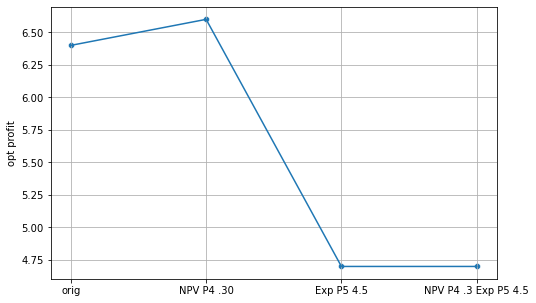

In [40]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = results.index, y = 'opt profit', data = results)
sns.lineplot(x = results.index, y = 'opt profit', data = results)
plt.grid()
plt.show()

In [41]:
coef = coef_orig.copy() #reset to original

##### [Back to Top](#Top)